In [1]:
import pandas as pd

In [ ]:
# import bz2

# with bz2.open("Host Events/wls_day-02.bz2", "rt") as f:
#     for i in range(20):
#         print(f.readline())


In [3]:
host_events_data = pd.read_csv(
    "Host Events/wls_day-02.bz2",
    compression="bz2",
    on_bad_lines='skip',
    nrows=200000  # only load the first 50k rows
)


In [ ]:
host_events_data = pd.read_csv(
    "Host Events/wls_day-02.bz2",
    compression="bz2",
    on_bad_lines='skip',
    nrows=100000  # only load the first 50k rows
)


In [4]:
logon_data = pd.read_csv(r"Dataset 1/logon.csv")
device_data = pd.read_csv(r"Dataset 1/device.csv")
http_data = pd.read_csv(r"Dataset 1/http.csv", nrows=200000)


In [5]:
device_data['datetime'] = pd.to_datetime(device_data['date'], format='%m/%d/%Y %H:%M:%S')

In [6]:
device_data['only_date'] = device_data['datetime'].dt.date
device_data['only_time'] = device_data['datetime'].dt.time

# Convert to epoch (milliseconds)
device_data['epoch_ms'] = device_data['datetime'].astype('int64') // 10**6

# Weekend flag
device_data['is_weekend'] = device_data['datetime'].dt.weekday >= 5

In [54]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Extract hour for histogram
device_data['hour'] = device_data['datetime'].dt.hour

# Create subplot layout: 2 rows, 1 column
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Time Distribution - All Users", "Time Distribution - Weekends Users Only"))

# Histogram for all users
fig.add_trace(
    go.Histogram(x=device_data['hour'], nbinsx=24, name='All Users'),
    row=1, col=1
)

# Histogram for weekend users
fig.add_trace(
    go.Histogram(x=device_data[device_data['is_weekend']]['hour'], nbinsx=24, name='Weekend Users', marker_color='orange'),
    row=2, col=1
)

# Layout adjustments
fig.update_layout(
    height=600,
    width=800,
    title_text="Hourly Activity Distribution",
    xaxis_title="Hour of Day (0–23)",
    yaxis_title="Count",
    bargap=0.05,
)

# X-axis range and tick formatting
fig.update_xaxes(dtick=1, title="Hour (24h format)", row=2, col=1)

# Show the plot
fig.show()


In [11]:
wsl_data = pd.read_csv("Web Server Logs/all_datas_f.csv")

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define feature columns
feature_cols = [
    'single_q', 'double_q', 'dashes', 'braces', 'spaces',
    'percentages', 'semicolons', 'angle_brackets', 'special_chars',
    'path_length', 'body_length', 'badwords_count'
]

# Compute total (sum) of features grouped by class
totals = wsl_data.groupby('class')[feature_cols].sum().reset_index()

# Melt for plotting
class_0 = totals[totals['class'] == 0].melt(id_vars='class', var_name='Feature', value_name='Total')
class_1 = totals[totals['class'] == 1].melt(id_vars='class', var_name='Feature', value_name='Total')

# Create vertically stacked bar plots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Class = 0", "Class = 1"))

fig.add_trace(go.Bar(x=class_0['Feature'], y=class_0['Total'], name='Class 0'), row=1, col=1)
fig.add_trace(go.Bar(x=class_1['Feature'], y=class_1['Total'], name='Class 1', marker_color='indianred'), row=2, col=1)

fig.update_layout(
    height=700,
    width=1000,
    title_text="Total Feature Counts by Class",
    showlegend=False
)
fig.update_xaxes(tickangle=45)
fig.show()


In [53]:
bad_wsl_data = pd.read_csv("Web Server Logs/2bad_reqff.csv")
good_wsl_data = pd.read_csv("Web Server Logs/2good_reqff.csv")

In [54]:
wsl_data_trimmed = wsl_data[['method','path','body']]
bad_wsl_data_trimmed = bad_wsl_data[['method','path','body']]
good_wsl_data_trimmed = good_wsl_data[['method','path','body']]

17115.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [87]:
import os
import requests
import pandas as pd

BASE_API = "https://api.github.com/repos/swisskyrepo/PayloadsAllTheThings/contents"
BRANCH = "master"
DATA_FILE = "attack_payloads.parquet"  # Local cache

CATEGORIES = {
    "SQLi": "SQL Injection/Intruder",
    "XSS": "XSS Injection/Intruders",
    "RCE": "Command Injection/Intruder",
    "LFI": "Directory Traversal/Intruder"
}

def fetch_payloads():
    payload_data = []

    for attack_type, folder in CATEGORIES.items():
        print(f"📂 Fetching {attack_type} payloads...")
        api_url = f"{BASE_API}/{folder}?ref={BRANCH}"
        resp = requests.get(api_url)
        if resp.status_code != 200:
            print(f"❌ Failed to list {folder}")
            continue

        files = resp.json()
        for f in files:
            if f['name'].endswith(".txt"):
                raw_url = f['download_url']
                try:
                    text_data = requests.get(raw_url).text
                    for line in text_data.splitlines():
                        line = line.strip()
                        if line and not line.startswith(("#", "--")):
                            payload_data.append((attack_type, line, raw_url))
                except Exception as e:
                    print(f"⚠️ Failed to fetch {raw_url}: {e}")

    df = pd.DataFrame(payload_data, columns=["attack_type", "payload", "source"])
    df.drop_duplicates(subset=["payload"], inplace=True)
    return df

def get_payload_df():
    if os.path.exists(DATA_FILE):
        print(f"✅ Loading cached payloads from {DATA_FILE}")
        return pd.read_parquet(DATA_FILE)
    
    print("⚡ No local cache found, fetching from GitHub...")
    df = fetch_payloads()
    df.to_parquet(DATA_FILE, index=False, engine="fastparquet")
    print(f"💾 Saved payloads to {DATA_FILE}")
    return df

payload_df = get_payload_df()
print(f"\nTotal payloads: {len(payload_df)}")
print(payload_df.head())


⚡ No local cache found, fetching from GitHub...
📂 Fetching SQLi payloads...
📂 Fetching XSS payloads...
📂 Fetching RCE payloads...
📂 Fetching LFI payloads...
💾 Saved payloads to attack_payloads.parquet

Total payloads: 26290
  attack_type payload                                             source
0        SQLi     '-'  https://raw.githubusercontent.com/swisskyrepo/...
1        SQLi     ' '  https://raw.githubusercontent.com/swisskyrepo/...
2        SQLi     '&'  https://raw.githubusercontent.com/swisskyrepo/...
3        SQLi     '^'  https://raw.githubusercontent.com/swisskyrepo/...
4        SQLi     '*'  https://raw.githubusercontent.com/swisskyrepo/...


In [ ]:
import re
import urllib.parse
import pandas as pd

def engineer_http_features(df):

    ATTACK_PATTERNS = {
    "sql_injection": r"('|\"|--|;|\b(union|select|insert|update|delete|drop|alter)\b)",
    "xss": r"(<script|alert\(|onerror=|onload=|\bjavascript:\b)",
    "path_traversal": r"(\.\./|\.\\|~/|\\\.\.)",
    "command_injection": r"(\b(powershell|cmd\.exe|wget|curl|bash|sh)\b|\|\||&&|`|\\x[0-9a-fA-F]{2})",
    "ssrf": r"(\b(localhost|127\.0\.0\.1|192\.168\.|10\.|172\.(1[6-9]|2[0-9]|3[0-1])\.)\b|(http|https)://[^\s]*)",
    "obfuscation": r"(\\x[0-9a-fA-F]{2}|%[0-9a-fA-F]{2}|&#x[0-9a-fA-F]{2};)",
}
    
    def count_occurrences(text, chars):
        return sum(text.count(c) for c in chars)
    
    def get_entropy(text):
        from collections import Counter
        import math
        counts = Counter(text)
        prob = [c / len(text) for c in counts.values()]
        return -sum(p * math.log2(p) for p in prob)
    
    features = []
    
    for _, row in df.iterrows():
        path = urllib.parse.unquote_plus(str(row['path']))
        body = urllib.parse.unquote_plus(str(row['body']) if pd.notnull(row['body']) else "")
        combined = f"{path} {body}"

        # Basic features
        row_features = {
            "single_q": combined.count("'"),
            "double_q": combined.count('"'),
            "dashes": combined.count('-'),
            "braces": count_occurrences(combined, "{}()[]"),
            "percentages": combined.count('%'),
            "semicolons": combined.count(';'),
            "path_length": len(path),
            "body_length": len(body),
            "entropy": get_entropy(combined),
        }

        # Attack pattern flags
        for name, pattern in ATTACK_PATTERNS.items():
            row_features[f"attack_{name}"] = bool(re.search(pattern, combined, re.IGNORECASE))
        
        features.append(row_features)
    
    return pd.DataFrame(features)


In [19]:
wsl_feature_df = engineer_http_features(wsl_data_trimmed)
wsl_result = pd.concat([wsl_data_trimmed, wsl_feature_df], axis=1)

In [46]:
bad_wsl_feature_df = engineer_http_features(bad_wsl_data_trimmed)
bad_wsl_result = pd.concat([bad_wsl_data_trimmed, bad_wsl_feature_df], axis=1)

In [55]:
good_wsl_feature_df = engineer_http_features(good_wsl_data_trimmed)
good_wsl_result = pd.concat([good_wsl_data_trimmed, good_wsl_feature_df], axis=1)

In [17]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from hdbscan import HDBSCAN

In [18]:
top_features = ['spaces', 'badwords_count', 'braces', 'double_q', 'single_q']

In [22]:
# X = wsl_result[top_features]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
wsl_copy = wsl_result.copy()

In [23]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100,random_state=42)  # minimal setup
labels = iso_forest.fit_predict(wsl_feature_df)
wsl_copy['anomaly_flag'] = labels


In [79]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Let's say 'if_pred' contains IsolationForest predictions (-1 anomaly, 1 normal)
# and your DataFrame with features is called 'wsl_data'
feature_cols = [
    'single_q', 'double_q', 'dashes', 'braces', 'spaces',
    'percentages', 'semicolons', 'angle_brackets', 'special_chars',
    'path_length', 'body_length', 'badwords_count'
]

# Compute totals grouped by Isolation Forest prediction
totals = wsl_copy.groupby('anomaly_flag')[feature_cols].sum().reset_index()

# Melt for plotting
normals = totals[totals['anomaly_flag'] == 1].melt(id_vars='anomaly_flag', var_name='Feature', value_name='Total')
anomalies = totals[totals['anomaly_flag'] == -1].melt(id_vars='anomaly_flag', var_name='Feature', value_name='Total')

# Create vertically stacked bar plots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    subplot_titles=("Normal (IF = 1)", "Anomalies (IF = -1)"))

fig.add_trace(go.Bar(x=normals['Feature'], y=normals['Total'], name='Normal', marker_color='steelblue'), row=1, col=1)
fig.add_trace(go.Bar(x=anomalies['Feature'], y=anomalies['Total'], name='Anomaly', marker_color='indianred'), row=2, col=1)

fig.update_layout(
    height=700,
    width=1000,
    title_text="Total Feature Counts by Isolation Forest Prediction",
    showlegend=False
)
fig.update_xaxes(tickangle=45)
fig.show()


In [24]:
X = wsl_feature_df
y = wsl_data['class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [25]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[55  3]
 [ 5 42]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        58
           1       0.93      0.89      0.91        47

    accuracy                           0.92       105
   macro avg       0.93      0.92      0.92       105
weighted avg       0.92      0.92      0.92       105



In [47]:
bad_wsl_result['class'] = [1] * len(bad_wsl_result)

In [48]:
bad_y_pred = model.predict(bad_wsl_feature_df)

print(confusion_matrix(bad_wsl_result['class'], bad_y_pred))
print(classification_report(bad_wsl_result['class'], bad_y_pred))

[[   0    0]
 [ 741 4769]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      5510

    accuracy                           0.87      5510
   macro avg       0.50      0.43      0.46      5510
weighted avg       1.00      0.87      0.93      5510



/home/fedorabox/.pyenv/versions/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fedorabox/.pyenv/versions/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fedorabox/.pyenv/versions/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

In [56]:
good_wsl_result['class'] = [0] * len(good_wsl_data)

In [57]:
good_y_pred = model.predict(good_wsl_feature_df)

print(confusion_matrix(good_wsl_result['class'], good_y_pred))
print(classification_report(good_wsl_result['class'], good_y_pred))

[[284   3]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       287
           1       0.00      0.00      0.00         0

    accuracy                           0.99       287
   macro avg       0.50      0.49      0.50       287
weighted avg       1.00      0.99      0.99       287



/home/fedorabox/.pyenv/versions/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fedorabox/.pyenv/versions/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fedorabox/.pyenv/versions/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

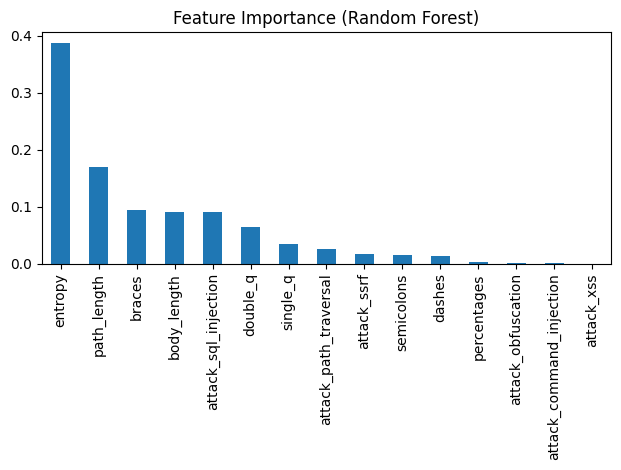

In [70]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_cols = wsl_feature_df.columns.to_list()
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

feat_imp.plot(kind='bar', title='Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


In [ ]:
print(feat_imp)